In [6]:
###########################
#  Master thesis
# 
# UNIVERSITY: 
#  Faculty of Information Technology, Brno University of Technology
# 
# AUTHOR:
#  Aleš Kašpárek          <xkaspa48@stud.fit.vutbr.cz>
###########################

import json
import torch
import math

import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset, DataLoader

In [2]:
def split_sequence(sequence, n_steps):
    x, y = list(), list()
    for i in range(len(sequence)):
        
        end_ix = i + n_steps
        
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x, dtype=np.float32), np.array(y, dtype=np.float32)

class NetworkAnalyticsDataset(Dataset):
    def __init__(self,feature,target):
        self.feature = feature
        self.target = target
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self,idx):
        item = self.feature[idx]
        label = self.target[idx]
        
        return item, label
    
# https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8489399
class TimeseriesCNN(nn.Module):
    def __init__(self, input_channels) -> None:
        super(TimeseriesCNN,self).__init__()

        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=1)
        self.conv2 = nn.Conv1d(64, 96, kernel_size=1)

        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(96, 20)
        self.fc2 = nn.Linear(20, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = torch.flatten(x, start_dim=1)
        # x = x.view(-1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x.squeeze(1)

In [17]:
RESULTS = {}

def train_fnc(config):
    network_analytics = pd.read_csv('./data/Network_Analytics.csv')
    network_analytics['Timestamp'] = pd.to_datetime(network_analytics['Timestamp'])
    network_analytics = network_analytics.set_index('Timestamp')

    train_len = int(len(network_analytics) * 0.80)
    valid_len = int(len(network_analytics) * 0.15)

    train_data = network_analytics[:train_len]
    valid = network_analytics[train_len:(train_len + valid_len)]
    test = network_analytics[train_len + len(valid):]

    train_x,train_y = split_sequence(train_data['OutboundUtilzation (%)'].values, config["channels"])
    valid_x,valid_y = split_sequence(valid['OutboundUtilzation (%)'].values, config["channels"])
    test_x,test_y = split_sequence(test['OutboundUtilzation (%)'].values, config["channels"])

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = TimeseriesCNN(config["channels"]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    train_data = NetworkAnalyticsDataset(train_x.reshape(train_x.shape[0],train_x.shape[1], 1), train_y)
    valid = NetworkAnalyticsDataset(valid_x.reshape(valid_x.shape[0],valid_x.shape[1], 1), valid_y)
    test = NetworkAnalyticsDataset(test_x.reshape(test_x.shape[0],test_x.shape[1], 1), test_y)

    train_loader = DataLoader(train_data, batch_size=1024, shuffle=False)
    valid_loader = DataLoader(valid, batch_size=1, shuffle=False)
    test_loader = DataLoader(test, batch_size=1, shuffle=False)

    best_loss = np.inf

    for epoch in range(100):
        model.train()
        
        for idx, (inputs,labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())
            loss = criterion(preds,labels)
            loss.backward()
            optimizer.step()
        
        running_loss = .0
        model.eval()
        predicted = []
        actuals = []
        
        with torch.no_grad():
            for idx, (inputs, labels) in enumerate(test_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                preds = model(inputs.float())
                loss = criterion(preds,labels)
                running_loss += loss
                predicted.extend(preds.detach().cpu().numpy())
                actuals.extend(labels.detach().cpu().numpy())
                
            valid_loss = float(mean_squared_error(actuals, predicted))
        if valid_loss < best_loss:
            # print("Epoch %d: best RMSE %.4f, new RMSE %.4f" % (epoch, best_loss, valid_loss))
            best_loss = valid_loss

    RESULTS[config['channels']] = best_loss
    print("Finished Training")


In [ ]:
for x in range(1, 51):
    train_fnc({'channels' : x})

with open('../outputs/cnn_channels.json', 'w') as json_file:
    json.dump(RESULTS, json_file)

5


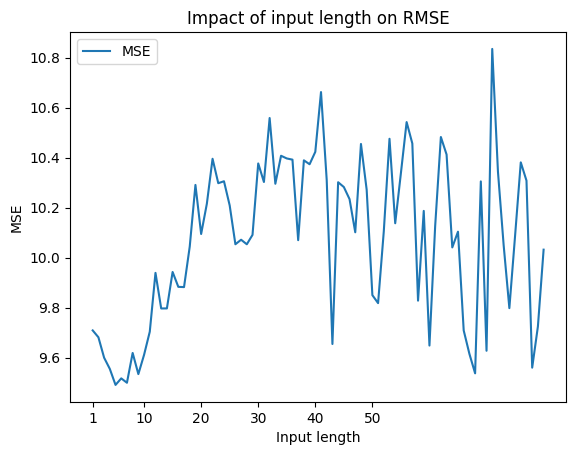

In [7]:
with open('../outputs/cnn_channels.json', 'r') as json_file:
    res = json.load(json_file)
d = {int(k):v for k,v in res.items()}

lists = sorted(d.items())
x, y = zip(*lists)
print(min(d, key=d.get))
plt.xlabel('Input length')
plt.ylabel('MSE')
plt.title('Impact of input length on RMSE')
plt.plot(x, y, label='MSE')
plt.xticks([1, 10, 20, 30, 40, 50])
plt.legend(loc='best')
plt.show()